This notebook try to find an optimal team for the Scarlet & Violet games.

In [180]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import requests
from PIL import Image
from io import BytesIO

## Types distribution

First of all let's visualise the distribution of pokemon types that we can encounter in Paldea.

In [181]:
paldea = pd.read_csv('datasets/paldea.csv')
paldea.head()

,name,type_1,type_2,base_hp,base_atk,base_def,base_sp_atk,base_sp_def,base_speed
0,Sprigatito,grass,NaN,40,61,54,45,45,65
1,Floragato,grass,NaN,61,80,63,60,63,83
2,Meowscarada,grass,dark,76,110,70,81,70,123
3,Fuecoco,fire,NaN,67,45,59,63,40,36
4,Crocalor,fire,NaN,81,55,78,90,58,49


In [182]:
types_list = pd.concat([paldea['type_1'], paldea['type_2']])
frequencies = types_list.value_counts()

In [183]:
frequencies_indices = frequencies.index.tolist()
frequencies_counts = frequencies.values.tolist()

In [184]:
colors = {
    'normal': '#A8A77A',
    'fire': '#EE8130',
    'water': '#6390F0',
    'electric': '#F7D02C',
    'grass': '#7AC74C',
    'ice': '#96D9D6',
    'fighting': '#C22E28',
    'poison': '#A33EA1',
    'ground': '#E2BF65',
    'flying': '#A98FF3',
    'psychic': '#F95587',
    'bug': '#A6B91A',
    'rock': '#B6A136',
    'ghost': '#735797',
    'dragon': '#6F35FC',
    'dark': '#705746',
    'steel': '#B7B7CE',
    'fairy': '#D685AD',
}

color_palette = [colors[t] for t in frequencies_indices]

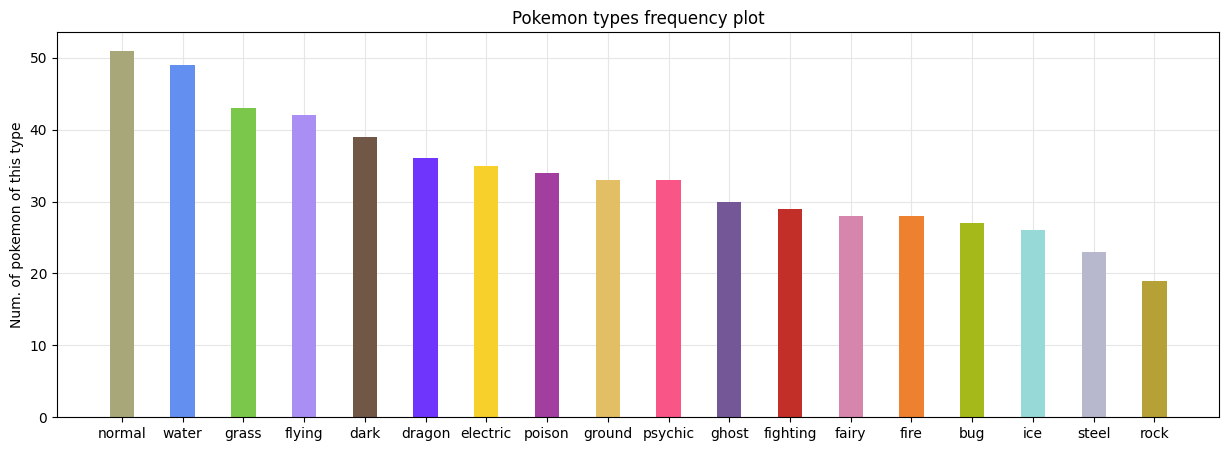

In [185]:
plt.bar(x=frequencies_indices, height=frequencies_counts, width=0.4, color=color_palette, zorder=2)

plt.ylabel('Num. of pokemon of this type')
plt.title('Pokemon types frequency plot')

plt.grid(color='0.9', zorder=1)

fig = plt.gcf()
fig.set_size_inches(15, 5)

## Team building

We now iteratively compose a pokemon team that contains all the pokemon necessary to combat the types in the head of the frquencies list ('normal' excluded, because I think I had never seriously combated a normal pokemon).

We introduce some randomness at a certain point, so that multiple runs of this scripts can bring to different teams.

In [186]:
randomness = 5      # increasing this parameter will build a more random but less optimal team

In [187]:
def computeAttackTypePrevalence(pokemon_name):
    """A function to see if a pokemon has more physical or special attacks."""
    
    attackdex = pd.read_csv(f'datasets/attackdex/paldea/{pokemon_name}.csv')

    attack_types_frequencies = attackdex['category'].value_counts()
    try:
        physical_frequency = attack_types_frequencies['physical']
    except:
        physical_frequency = 0
    try:
        special_frequency = attack_types_frequencies['special']
    except:
        special_frequency = 0

    if physical_frequency > special_frequency:
        return 'physical'
    elif special_frequency > physical_frequency:
        return 'special'

In [188]:
team = []
team_types = []

In [189]:
weaknesses = pd.read_csv('datasets/weaknesses.csv')
weaknesses.columns = weaknesses.columns.str.lower()
weaknesses['attacking'] = weaknesses['attacking'].str.lower()

weaknesses

,attacking,normal,fire,water,electric,grass,ice,fighting,poison,ground,flying,psychic,bug,rock,ghost,dragon,dark,steel,fairy
0,normal,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.0,1.0,1.0,0.5,1.0
1,fire,1,0.5,0.5,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,0.5,1.0,0.5,1.0,2.0,1.0
2,water,1,2.0,0.5,1.0,0.5,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,0.5,1.0,1.0,1.0
3,electric,1,1.0,2.0,0.5,0.5,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0
4,grass,1,0.5,2.0,1.0,0.5,1.0,1.0,0.5,2.0,0.5,1.0,0.5,2.0,1.0,0.5,1.0,0.5,1.0
5,ice,1,0.5,0.5,1.0,2.0,0.5,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,0.5,1.0
6,fighting,2,1.0,1.0,1.0,1.0,2.0,1.0,0.5,1.0,0.5,0.5,0.5,2.0,0.0,1.0,2.0,2.0,0.5
7,poison,1,1.0,1.0,1.0,2.0,1.0,1.0,0.5,0.5,1.0,1.0,1.0,0.5,0.5,1.0,1.0,0.0,2.0
8,ground,1,2.0,1.0,2.0,0.5,1.0,1.0,2.0,1.0,0.0,1.0,0.5,2.0,1.0,1.0,1.0,2.0,1.0
9,flying,1,1.0,1.0,0.5,2.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,0.5,1.0,1.0,1.0,0.5,1.0


In [190]:
ordered_types = frequencies_indices[1:]

In [191]:
attackable_types = 0
weak_against = []

for defending_type in ordered_types:

    supereffective_attackers = weaknesses[weaknesses[defending_type]==2.0]['attacking'].to_list()

    random_int = random.randint(0, len(supereffective_attackers)-1)
    chosen_supereffective_type = supereffective_attackers[random_int]

    if chosen_supereffective_type in team_types:

        attackable_types += 1

    else:

        if len(team) < 6:

            type_1_candidates = paldea[paldea['type_1'] == chosen_supereffective_type]
            type_2_candidates = paldea[paldea['type_2'] == chosen_supereffective_type]
            candidates = pd.concat([type_1_candidates, type_2_candidates])

            candidates['attack_prevalence'] = candidates['name'].apply(computeAttackTypePrevalence)

            random_int = random.randint(0, 1)
            skills = ['base_atk', 'base_sp_atk']
            atk_categories = ['physical', 'special']
            chosen_skill = skills[random_int]
            chosen_atk_category = atk_categories[random_int]

            candidates = candidates.sort_values(by=chosen_skill, ascending=False)
            filtered_candidates = candidates[candidates['attack_prevalence'] == chosen_atk_category]

            top_candidates = filtered_candidates.head(randomness)
            try:
                selection = top_candidates.sample(1)
            except:     # in case there are no candidates with physical/special attacks
                chosen_skill = skills[random_int%1]
                chosen_atk_category = atk_categories[random_int%1]
                candidates = candidates.sort_values(by=chosen_skill, ascending=False)
                filtered_candidates = candidates[candidates['attack_prevalence'] == chosen_atk_category]
                top_candidates = filtered_candidates.head(randomness)
                selection = top_candidates.sample(1)

            pokedex_index = selection.index.to_list()[0]+1
            pokemon_name = selection['name'].values[0]
            team.append(f"{pokedex_index}: {pokemon_name}")

            team_types.append(selection['type_1'].values[0])
            type_2 = selection['type_2'].values[0]
            if not pd.isna(type_2):
                team_types.append(type_2)

            attackable_types += 1

        else:

            weak_against.append(defending_type)

In [192]:
print(f"Strong against {attackable_types}/{len(ordered_types)} types.")
print(f"Weak against {weak_against}")

Strong against 14/17 types.
Weak against ['fairy', 'bug', 'rock']


In [193]:
team

['245: Toedscruel',
 '278: Salamence',
 '318: Tyranitar',
 '384: Iron Hands',
 '284: Hatterene',
 '70: Gengar']

## Team image

Finally, let's build a pretty team image with the pokemon that we found.

In [194]:
urls_list = [f"https://img.pokemondb.net/artwork/large/{team_member.split(': ')[1].lower()}.jpg"
                for team_member in team]
urls_list = [url.replace(' ', '-') for url in urls_list]

In [195]:
# Create a new image with a white background
team_image = Image.new('RGBA', (1440, 900), (255, 255, 255, 255))

# Define the space between images
space = 40

# Define the number of columns and rows
columns = 3
rows = 2

# Calculate the total space that will be used by the spaces between the images
total_space_width = space * (columns - 1)
total_space_height = space * (rows - 1)

# Calculate the width and height of each image, considering the spaces between them
image_width = (team_image.width - total_space_width) // columns
image_height = (team_image.height - total_space_height) // rows

# Paste each image into the team image
for i, url in enumerate(urls_list):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((image_width, image_height))
    if img.mode != 'RGBA':
        img = img.convert('RGBA')

    # Calculate the row and column for the current image
    row = i // columns
    col = i % columns

    # Calculate the top and left coordinates for the pasted image, adding space between images
    top = row * (image_height + space)
    left = col * (image_width + space)

    team_image.paste(img, (left, top), img)

# Save the image
team_image.save('team.png')